In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf


RANDOM_STATE = 2020
VAL_SPLIT = 0.2

#### Select running platform to easy running on each platform:

In [3]:
PLATFORM = 'kaggle'

if PLATFORM == 'kaggle':
    path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
    path_test  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
    
elif PLATFORM == 'colab':
    path_train = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
    path_test  = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/test'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif PLATFORM == 'local':
    path_train = '../data/raw/train'
    path_test  = '../data/raw/test'

else:
    sys.exit('ERROR: PLEASE ENTER "kaggle", "colab" or "local"')

### Import training data:

In [4]:
BATCH_SIZE = 1349+3883
TARGET_SIZE = 128

generator = ImageDataGenerator()
gen_train = generator.flow_from_directory(directory=path_train, 
                                          target_size=(TARGET_SIZE, TARGET_SIZE), 
                                          batch_size=BATCH_SIZE, 
                                          seed=RANDOM_STATE)

train = next(gen_train)
images = train[0]
labels = train[1]
del gen_train, train # reduce memory usage

Found 5216 images belonging to 2 classes.


#### Define validation data *only* for testing model performance after fitting on 0.25 val split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, random_state=RANDOM_STATE, test_size=VAL_SPLIT)
del images
del labels

In [6]:
def plot_metrics(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

#### Define callbacks

In [7]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

### Define First Simple Model (FSM)

##### Uses only Dense layer

33/33 [==============================] - 0s 4ms/step - loss: 18894.5273 - accuracy: 0.9626
[18894.52734375, 0.9626436829566956]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


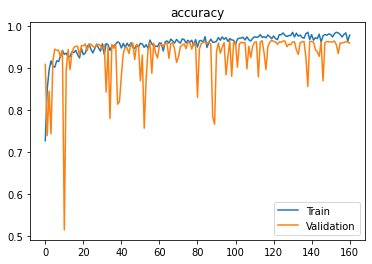

In [8]:
# Manually flatten Images array for input to Dense layer
shp = x_train.shape # temporary variable
x_train_flat = x_train.reshape(shp[0], 
                               shp[1]*shp[2]*shp[3])
shape = (x_train_flat.shape[1],)

# Manually flatten Images array for input to Dense layer
shp = x_val.shape # temporary variable
x_val_flat = x_val.reshape(shp[0], 
                             shp[1]*shp[2]*shp[3])
shape = (x_val_flat.shape[1],)



model = Sequential()
model.add(Dense(2, activation='softmax', input_shape=shape))

model.compile(optimizer='SGD', 
              metrics=['accuracy'], 
              loss='categorical_crossentropy')


fit = model.fit(x=x_train_flat, 
                y=y_train, 
                epochs=500,
                validation_data=(x_val_flat, y_val),
                callbacks=callbacks,
                verbose=0)

plot_metrics(fit.history)

model.load_weights('best_model.h5')
print(model.evaluate(x_val_flat, y_val));
model.summary()
del x_train_flat, x_val_flat

#### Add convolutional layer to previous model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      4736      
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1048578   
Total params: 1,053,314
Trainable params: 1,053,314
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 1s 20ms/step - loss: 0.9605 - accuracy: 0.8429


[0.9604525566101074, 0.8429118990898132]

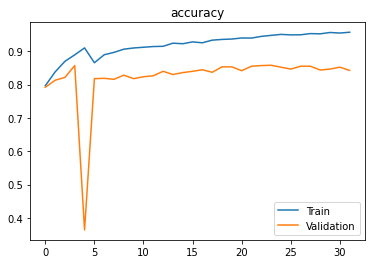

In [9]:
model = Sequential()
model.add(Conv2D(32,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Increase node count substantially

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     86528     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4194306   
Total params: 4,280,834
Trainable params: 4,280,834
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 7s 198ms/step - loss: 2.3772 - accuracy: 0.8161


[2.3771655559539795, 0.8160919547080994]

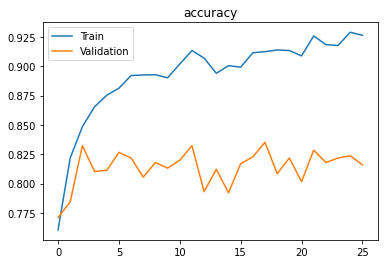

In [10]:
model = Sequential()
model.add(Conv2D(128,
                 kernel_size=15,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Instead, increase depth with pooling

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 8)         12552     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6728)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 13458     
Total params: 30,746
Trainable params: 30,746
Non-trainable params: 0
__________________________________________________

None

33/33 [==============================] - 1s 18ms/step - loss: 9844.0449 - accuracy: 0.2605


[9844.044921875, 0.26053640246391296]

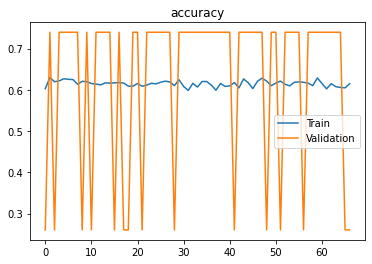

In [11]:
model = Sequential()
model.add(Conv2D(32,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Add Regularization to top Convolutional

In [12]:
LAMBDA = 0.005


# model.add(Dense(xxx kernel_regularizer=regularizers.l2(LAMBDA)))

#### Add Dropout to top Convolutional

In [13]:
DROPOUT = 0.3

# model.add(Dropout(DROPOUT))

#### Train top performing model on full training dataset (including "validation")

In [14]:
dont run below unless you want to combine training and validation

SyntaxError: invalid syntax (<ipython-input-14-42f97d5a4558>, line 1)

In [ ]:
ONLY RUN THIS CELL ONCE (UNCOMMENT THIS LINE BEFORE RUNNING, COMMENT AFTER RUNNING)
x_train_all = np.concatenate([x_train, x_val], axis=0)
y_train_all = np.concatenate([x_train, x_val], axis=0)
del x_train, y_train
del x_val, y_val

In [ ]:
top_fit = top_model.fit(x=x_train_all, 
                        y=y_train_all,
                        epochs=500,
                        callbacks=callbacks,
                        validation_data=VAL_SPLIT,
                        verbose=0)

plot_metrics(top_fit.history)

#model.load_weights('best_model.h5')
display(top_model.summary())

## Measure performance on Test data

In [ ]:
dont run below unless you want to delete all training data

In [ ]:
# Delete training data to increase available memory
#del x_train
#del y_train

BATCH_SIZE = 234+390

generator = ImageDataGenerator()
gen_test = generator.flow_from_directory(directory=path_test, 
                                          target_size=(TARGET_SIZE, TARGET_SIZE), 
                                          batch_size=BATCH_SIZE, 
                                          seed=RANDOM_STATE)

test = next(gen_test)
images_test = test[0]
labels_test = test[1]
#del gen_train, train # reduce memory usage

In [ ]:
# Print evaluation results on test set
top_model.evaluate(images_test, labels_test)